# Comparison Between TreeValue and Tianshou Batch

In this section, we will take a look at the feature and performance of the [Tianshou Batch](https://github.com/thu-ml/tianshou) library, which is developed by Tsinghua Machine Learning Group.

Before starting the comparison, let us define some thing.

In [1]:
import torch 

_TREE_DATA_1 = {'a': 1, 'b': 2, 'x': {'c': 3, 'd': 4}}
_TREE_DATA_2 = {
    'a': torch.randn(2, 3), 
    'x': {
        'c': torch.randn(3, 4)
    },
}
_TREE_DATA_3 = {
    'obs': torch.randn(4, 84, 84),
    'action': torch.randint(0, 6, size=(1,)),
    'reward': torch.rand(1),
}

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read and Write Operation

Reading and writing are the two most common operations in the tree data structure based on the data model (TreeValue and Tianshou Batch both belong to this type), so this section will compare the reading and writing performance of these two libraries.

### TreeValue's Get and Set

In [2]:
from treevalue import FastTreeValue

t = FastTreeValue(_TREE_DATA_2)

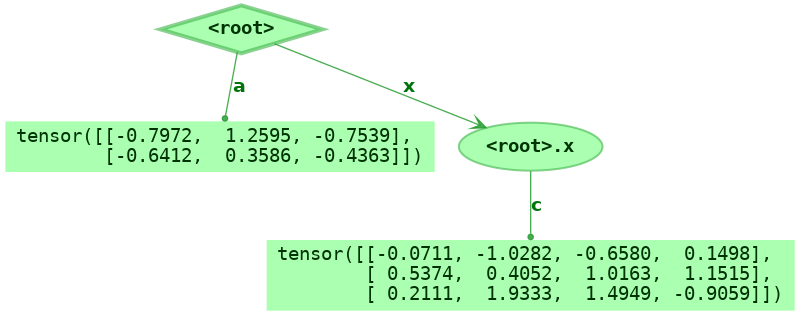

In [3]:
t

In [4]:
t.a

tensor([[-0.7972,  1.2595, -0.7539],
        [-0.6412,  0.3586, -0.4363]])

In [5]:
%timeit t.a

59.4 ns ± 0.0518 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


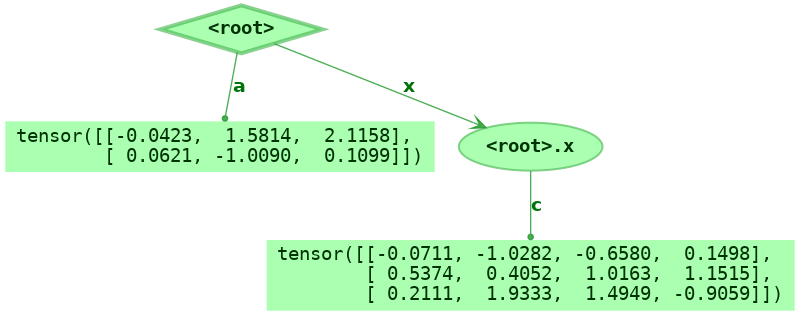

In [6]:
new_value = torch.randn(2, 3)
t.a = new_value

t

In [7]:
%timeit t.a = new_value

68.5 ns ± 0.0647 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


### Tianshou Batch's Get and Set

In [8]:
from tianshou.data import Batch

b = Batch(**_TREE_DATA_2)

In [9]:
b

Batch(
    a: tensor([[-0.7972,  1.2595, -0.7539],
               [-0.6412,  0.3586, -0.4363]]),
    x: Batch(
           c: tensor([[-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059]]),
       ),
)

In [10]:
b.a

tensor([[-0.7972,  1.2595, -0.7539],
        [-0.6412,  0.3586, -0.4363]])

In [11]:
%timeit b.a

58.5 ns ± 0.0391 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [12]:
new_value = torch.randn(2, 3)
b.a = new_value

b

Batch(
    a: tensor([[ 1.8691, -1.7801, -1.5449],
               [-1.1956, -0.8395, -0.4006]]),
    x: Batch(
           c: tensor([[-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059]]),
       ),
)

In [13]:
%timeit b.a = new_value

484 ns ± 0.138 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Initialization

### TreeValue's Initialization

In [14]:
%timeit FastTreeValue(_TREE_DATA_1)

838 ns ± 6.04 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Tianshou Batch's Initialization

In [15]:
%timeit Batch(**_TREE_DATA_1)

11.5 µs ± 31 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Deep Copy Operation

In [16]:
import copy

### Deep Copy of TreeValue

In [17]:
t3 = FastTreeValue(_TREE_DATA_3)
%timeit copy.deepcopy(t3)

136 µs ± 552 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Deep Copy of Tianshou Batch

In [18]:
b3 = Batch(**_TREE_DATA_3)
%timeit copy.deepcopy(b3)

139 µs ± 342 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Stack, Concat and Split Operation

### Performance of TreeValue

In [19]:
trees = [FastTreeValue(_TREE_DATA_2) for _ in range(8)]

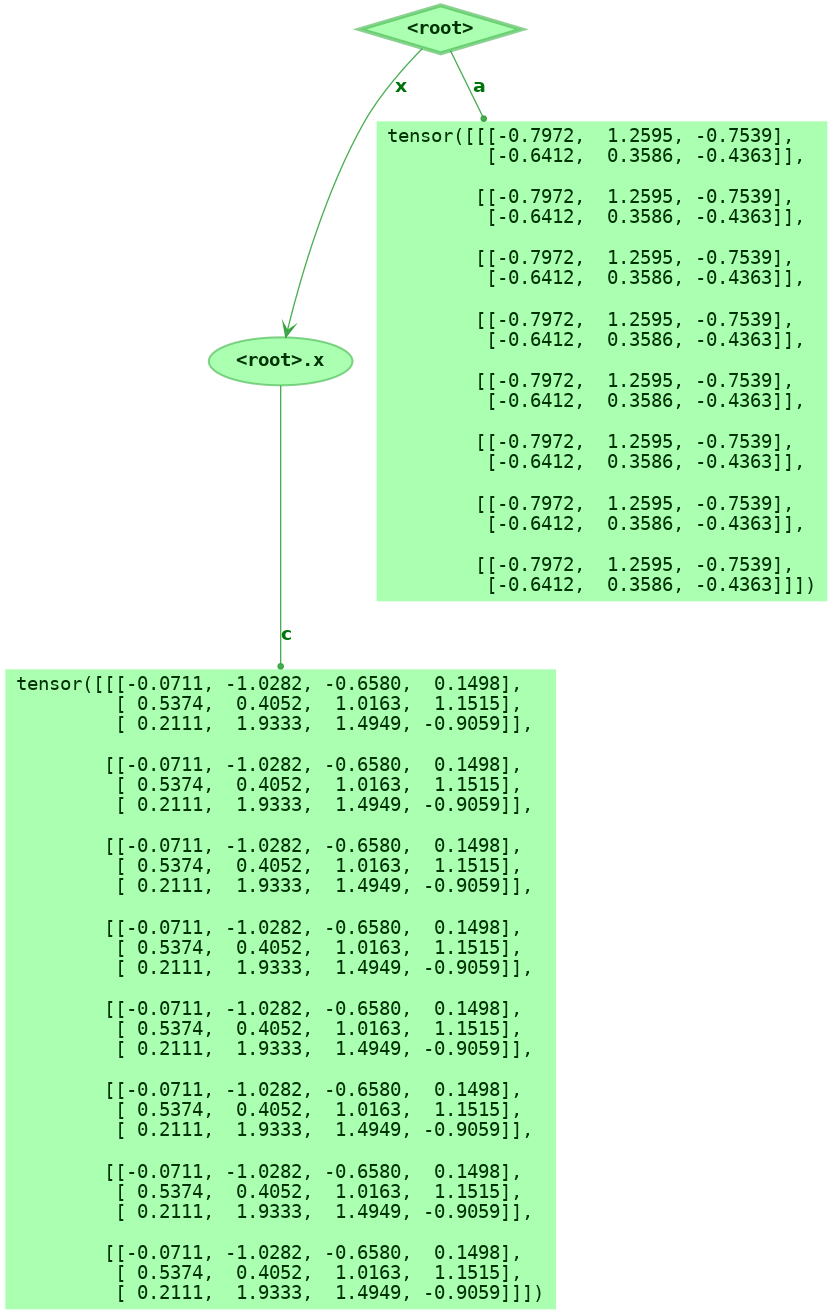

In [20]:
t_stack = FastTreeValue.func(subside=True)(torch.stack)

t_stack(trees)

In [21]:
%timeit t_stack(trees)

32.8 µs ± 35.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


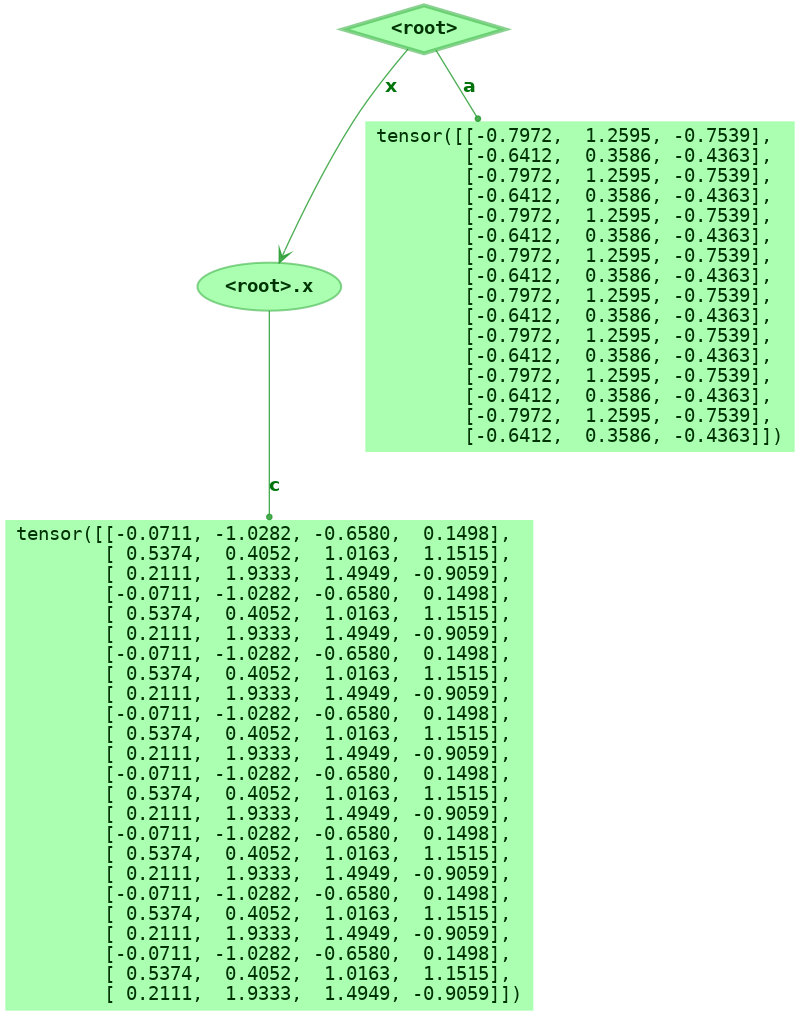

In [22]:
t_cat = FastTreeValue.func(subside=True)(torch.cat)

t_cat(trees)

In [23]:
%timeit t_cat(trees)

30.8 µs ± 96.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
t_split = FastTreeValue.func(rise=True)(torch.split)
tree = FastTreeValue({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1),
})

%timeit t_split(tree, 1)

59.9 µs ± 60.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Performance of Tianshou Batch

In [25]:
batches = [Batch(**_TREE_DATA_2) for _ in range(8)]

Batch.stack(batches)

Batch(
    x: Batch(
           c: tensor([[[-0.0711, -1.0282, -0.6580,  0.1498],
                       [ 0.5374,  0.4052,  1.0163,  1.1515],
                       [ 0.2111,  1.9333,  1.4949, -0.9059]],
              
                      [[-0.0711, -1.0282, -0.6580,  0.1498],
                       [ 0.5374,  0.4052,  1.0163,  1.1515],
                       [ 0.2111,  1.9333,  1.4949, -0.9059]],
              
                      [[-0.0711, -1.0282, -0.6580,  0.1498],
                       [ 0.5374,  0.4052,  1.0163,  1.1515],
                       [ 0.2111,  1.9333,  1.4949, -0.9059]],
              
                      [[-0.0711, -1.0282, -0.6580,  0.1498],
                       [ 0.5374,  0.4052,  1.0163,  1.1515],
                       [ 0.2111,  1.9333,  1.4949, -0.9059]],
              
                      [[-0.0711, -1.0282, -0.6580,  0.1498],
                       [ 0.5374,  0.4052,  1.0163,  1.1515],
                       [ 0.2111,  1.9333,  1.4949, -0.9059]],

In [26]:
%timeit Batch.stack(batches)

78.4 µs ± 99.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
Batch.cat(batches)

Batch(
    x: Batch(
           c: tensor([[-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059],
                      [-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059],
                      [-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059],
                      [-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059],
                      [-0.0711, -1.0282, -0.6580,  0.1498],
                      [ 0.5374,  0.4052,  1.0163,  1.1515],
                      [ 0.2111,  1.9333,  1.4949, -0.9059],
                      [-0.0711, -1.0282, -0.6580,  0.1498],
                   

In [28]:
%timeit Batch.cat(batches)

144 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
batch = Batch({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1)}
)

%timeit list(Batch.split(batch, 1, shuffle=False, merge_last=True))

308 µs ± 541 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
